<a href="https://colab.research.google.com/github/coriander4all/pyspark_lichess_exercises/blob/main/lichess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Lichess
Dorian Chevalerias -- Loup Perdu


## Setup

### Download data

In [1]:
import kagglehub

path = kagglehub.dataset_download("noobiedatascientist/lichess-september-2020-data")

print("Path to dataset files:", path)

100%|██████████| 324M/324M [00:06<00:00, 54.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3


Checking what the downloaded files look like

In [2]:
!head /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/*


==> /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Column information.txt <==
GAME: Game ID (not from lichess.org)

BlackElo: Elo rating of the player with the black pieces

BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces

Date: Date the game was played

ECO: Game opening (ECO notation)


==> /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Sept_20_analysis.csv <==
GAME,BlackElo,BlackRatingDiff,Date,ECO,Event,Opening,Result,Site,Termination,TimeControl,UTCTime,WhiteElo,WhiteRatingDiff,Black_elo_category,White_elo_category,starting_time,increment,Game_type,Total_moves,Black_blunders,White_blunders,Black_mistakes,White_mistakes,Black_inaccuracies,White_inaccuracies,Black_inferior_moves,White_inferior_moves,Black_ts_moves,White_ts_moves,Black_ts_blunders,White_ts_blunders,Black_ts_mistakes,White_ts_mistake,Black_long_moves,White_long_moves,Black_bad_l

In [3]:
import pandas as pd
csv_path = path +  "/Sept_20_analysis.csv"
data = pd.read_csv(csv_path, nrows=10)
data

,GAME,BlackElo,BlackRatingDiff,Date,ECO,Event,Opening,Result,Site,Termination,...,Black_ts_blunders,White_ts_blunders,Black_ts_mistakes,White_ts_mistake,Black_long_moves,White_long_moves,Black_bad_long_moves,White_bad_long_moves,Game_flips,Game_flips_ts
0,11,1143,6.0,2020.09.01,A02,Rated Blitz game,Bird Opening,0-1,https://lichess.org/hjb8FYm1,Time forfeit,...,0,0,0,0,2,1,1,1,8,0
1,14,1504,NaN,2020.09.01,A04,Rated Blitz game,Réti Opening,0-1,https://lichess.org/Iz2fbHuE,Normal,...,0,0,0,0,0,1,0,0,6,0
2,29,1933,1.0,2020.09.01,C41,Rated Blitz game,Philidor Defense,0-1,https://lichess.org/Cdj7flmY,Time forfeit,...,0,0,0,0,1,1,1,0,5,0
3,40,1710,10.0,2020.09.01,B23,Rated Blitz game,Sicilian Defense: Closed,0-1,https://lichess.org/WZQ9FEpD,Normal,...,4,0,0,0,3,1,1,0,8,1
4,55,1598,-1.0,2020.09.01,B03,Rated Rapid game,Alekhine Defense,1-0,https://lichess.org/ESlJl57U,Normal,...,0,0,0,0,0,0,0,0,2,0
5,56,2207,4.0,2020.09.01,E32,Rated Rapid game,"Nimzo-Indian Defense: Classical Variation, Ker...",0-1,https://lichess.org/0Qr4Q3Yr,Normal,...,0,0,0,0,1,1,0,1,6,0
6,70,1632,-5.0,2020.09.01,D00,Rated Bullet game,Queen's Pawn Game,1-0,https://lichess.org/5rdLi2Xy,Normal,...,0,0,0,0,0,1,0,0,3,0
7,72,1420,5.0,2020.09.01,D00,Rated Bullet game,Queen's Pawn Game: Mason Attack,0-1,https://lichess.org/UCrQJl9U,Time forfeit,...,0,0,0,0,1,2,1,1,18,0
8,162,942,-3.0,2020.09.01,C46,Rated Blitz tournament https://lichess.org/tou...,Four Knights Game: Italian Variation,1-0,https://lichess.org/6HICG50e,Normal,...,0,0,0,0,1,0,1,0,13,0
9,196,1500,180.0,2020.09.01,E73,Rated Rapid tournament https://lichess.org/tou...,"King's Indian Defense: Normal Variation, Stand...",0-1,https://lichess.org/5mPzDhFr,Time forfeit,...,0,0,0,0,3,4,0,3,3,0


### Setup spark

In [4]:
SPARK_VER="3.5.3"
!rm -f spark-$SPARK_VER-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -c https://downloads.apache.org/spark/spark-$SPARK_VER/spark-$SPARK_VER-bin-hadoop3.tgz
!ls -lh spark-$SPARK_VER-bin-hadoop3.tgz
!tar xf spark-$SPARK_VER-bin-hadoop3.tgz || echo "Extraction failed! File might be corrupted."
!pip install -q findspark

--2025-01-08 18:43:47--  https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.208.237, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400864419 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.3-bin-hadoop3.tgz’

spark-3.5.3-bin-had 100%[===================>] 382.29M  22.8MB/s    in 18s     

2025-01-08 18:44:06 (21.7 MB/s) - ‘spark-3.5.3-bin-hadoop3.tgz’ saved [400864419/400864419]

-rw-r--r-- 1 root root 383M Sep  9 05:35 spark-3.5.3-bin-hadoop3.tgz


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-" + SPARK_VER + "-bin-hadoop3"

---
## Work done

In [57]:
import findspark
from pyspark.sql import SparkSession

import pyspark.sql.functions as f
from pyspark.sql.functions import round, col



findspark.init()

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

df = spark.read.csv(csv_path, inferSchema=True, header=True)


### Checking the data

In [7]:
df.show(10)

+----+--------+---------------+----------+---+--------------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|               Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_move

In [8]:
#Uncoment (long)

#Checking the missing values

df.select(*[
    (
        f.count(f.when((f.isnan(c) | f.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else f.count(f.when(f.col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df.columns
]).show()

+----+--------+---------------+----+---+-----+-------+------+----+-----------+-----------+-------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|Date|ECO|Event|Opening|Result|Site|Termination|TimeControl|UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Bl

There are many missing values in the following data fields: BlackRatingDiff, WhiteRatingDiff, starting_time and increment. These should not bother us for the purpose of these exercise.

In [9]:
df.dtypes

[('GAME', 'int'),
 ('BlackElo', 'int'),
 ('BlackRatingDiff', 'int'),
 ('Date', 'string'),
 ('ECO', 'string'),
 ('Event', 'string'),
 ('Opening', 'string'),
 ('Result', 'string'),
 ('Site', 'string'),
 ('Termination', 'string'),
 ('TimeControl', 'string'),
 ('UTCTime', 'timestamp'),
 ('WhiteElo', 'int'),
 ('WhiteRatingDiff', 'int'),
 ('Black_elo_category', 'string'),
 ('White_elo_category', 'string'),
 ('starting_time', 'int'),
 ('increment', 'int'),
 ('Game_type', 'string'),
 ('Total_moves', 'int'),
 ('Black_blunders', 'int'),
 ('White_blunders', 'int'),
 ('Black_mistakes', 'int'),
 ('White_mistakes', 'int'),
 ('Black_inaccuracies', 'int'),
 ('White_inaccuracies', 'int'),
 ('Black_inferior_moves', 'int'),
 ('White_inferior_moves', 'int'),
 ('Black_ts_moves', 'int'),
 ('White_ts_moves', 'int'),
 ('Black_ts_blunders', 'int'),
 ('White_ts_blunders', 'int'),
 ('Black_ts_mistakes', 'int'),
 ('White_ts_mistake', 'int'),
 ('Black_long_moves', 'int'),
 ('White_long_moves', 'int'),
 ('Black_bad

In [10]:
df.select('Opening').distinct().show(truncate=False)

+-------------------------------------------------------------------------------------+
|Opening                                                                              |
+-------------------------------------------------------------------------------------+
|Grünfeld Defense: Exchange Variation                                                 |
|Four Knights Game: Spanish Variation, Rubinstein Variation Accepted                  |
|Ruy Lopez: Berlin Defense, Tarrasch Trap                                             |
|King's Gambit, Falkbeer Countergambit, Blackburne Attack                             |
|King's Indian Attack: Wahls Defense                                                  |
|Alekhine Defense: Modern Variation, Larsen-Haakert Variation                         |
|Modern Defense: Randspringer Variation                                               |
|Caro-Kann Defense: Accelerated Panov Attack, Open Variation                          |
|Ruy Lopez: Classical Variation,

In [11]:
df.select('White_elo_category').distinct().show(truncate=False)

+------------------+
|White_elo_category|
+------------------+
|GM rating         |
|High rating       |
|Low rating        |
+------------------+



### Modifications

In [ ]:
from pyspark.sql.functions import col, avg

df = df.withColumn("White_moves", ((col("Total_moves")+1)/2).cast("int")) #the original data doesn't have the number of moves per player
df = df.withColumn("Black_moves", (col("Total_moves")/2).cast("int"))


def categorize_elo(elo):
    if elo < 1200:
        return 'Novice'
    elif 1200 <= elo <= 1499:
      return 'Occasional Player'
    elif 1500 <= elo <= 1799:
        return 'Good Club Player'
    elif 1800 <= elo <= 1999:
        return 'Very Good Club Player'
    elif 2000 <= elo <= 2399:
        return 'National/International Level (IM)'
    elif 2400 <= elo <= 2800:
        return 'GMI/World Champion'
    else:
        return 'Unknown'

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

categorize_elo_udf = udf(categorize_elo, StringType())

df = df.withColumn("white_elo_category", categorize_elo_udf(col("WhiteElo")))
df = df.withColumn("black_elo_category", categorize_elo_udf(col("BlackElo")))

df = df.withColumn("Elo_diff", col("WhiteElo") - col("BlackElo"))

In [59]:
df_blitz =  df.filter(f.col("Game_type") == "Blitz")

In [63]:
df.show(10)

+----+--------+---------------+----------+---+--------------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+--------------------+--------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|               Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|  black_elo_category|  white_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_

---
## Exercice 1
What is the rate of blunders, mistakes and inaccuracies per move and per level category on Blitz games?


Since there are many games played between players of different categories, in particular between GM and high level players (as shown below), considering only games of the same game

In [24]:
from pyspark.sql.functions import col, count

elo_matrix = df_blitz.groupBy("White_elo_category").pivot("Black_elo_category").agg(count("*"))

elo_matrix.show()

+--------------------+------------------+----------------+---------------------------------+------+-----------------+-------+---------------------+
|  White_elo_category|GMI/World Champion|Good Club Player|National/International Level (IM)|Novice|Occasional Player|Unknown|Very Good Club Player|
+--------------------+------------------+----------------+---------------------------------+------+-----------------+-------+---------------------+
|    Good Club Player|               462|          432542|                            11753|  6771|            53172|      5|                45042|
|  GMI/World Champion|             13929|             442|                             9307|    35|              125|    218|                  886|
|             Unknown|               214|              13|                               39|     6|                5|     18|                    6|
|Very Good Club Pl...|               957|           44766|                            37783|  1513|             

In [15]:
mistake_rates = df_blitz.groupBy("White_elo_category", "Black_elo_category").agg(
    (f.avg("White_blunders") / f.avg("White_moves")).alias("White_blunders_rate"),
    (f.avg("White_mistakes") / f.avg("White_moves")).alias("White_errors_rate"),
    (f.avg("White_inaccuracies") / f.avg("White_moves")).alias("White_inaccuracies_rate"),
    (f.avg("Black_blunders") / f.avg("Black_moves")).alias("Black_blunders_rate"),
    (f.avg("Black_mistakes") / f.avg("Black_moves")).alias("Black_errors_rate"),
    (f.avg("Black_inaccuracies") / f.   avg("Black_moves")).alias("Black_inaccuracies_rate")
)

In [16]:
mistake_rates.show()

+--------------------+--------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+-----------------------+
|  White_elo_category|  Black_elo_category| White_blunders_rate|  White_errors_rate|White_inaccuracies_rate| Black_blunders_rate|   Black_errors_rate|Black_inaccuracies_rate|
+--------------------+--------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+-----------------------+
|Very Good Club Pl...|              Novice| 0.04302061595615383|0.07106657188066136|    0.07030981264475887| 0.06964799019838838| 0.09554215164224117|    0.09749776165119457|
|National/Internat...|    Good Club Player| 0.03551383806964348| 0.0730517403034268|    0.07440198697808527| 0.05220851380671401| 0.09348320963734524|    0.09484960329215472|
|              Novice|    Good Club Player| 0.09084266570542017|0.09912854561130893|    0.10201715630160407|  0.0696490521163

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

mistake_rates_pd = mistake_rates.toPandas()



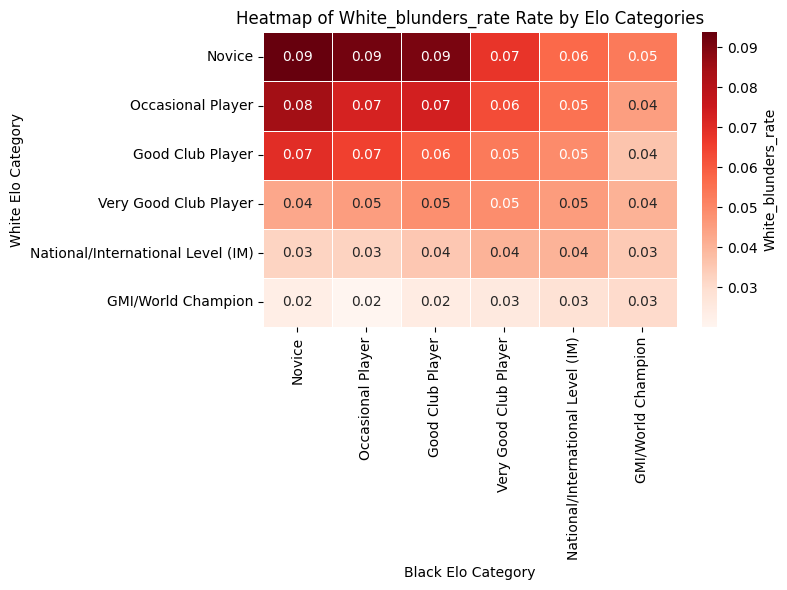

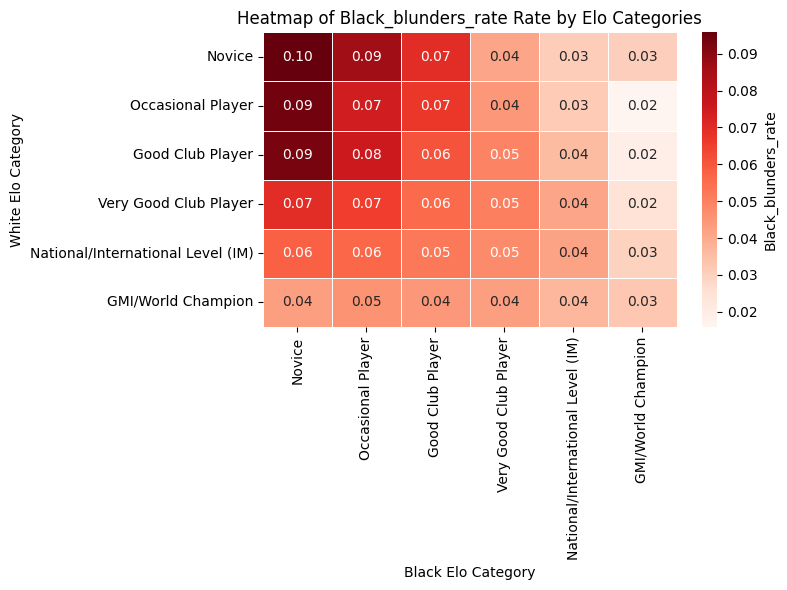

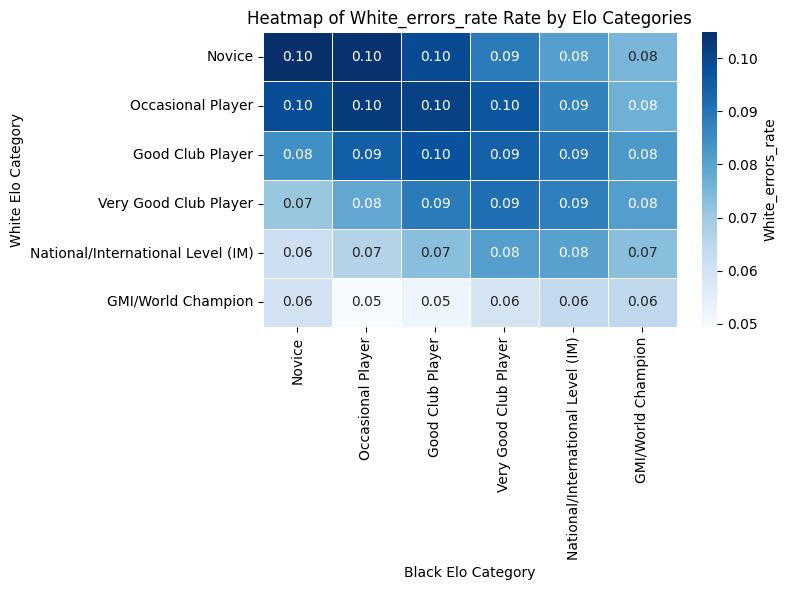

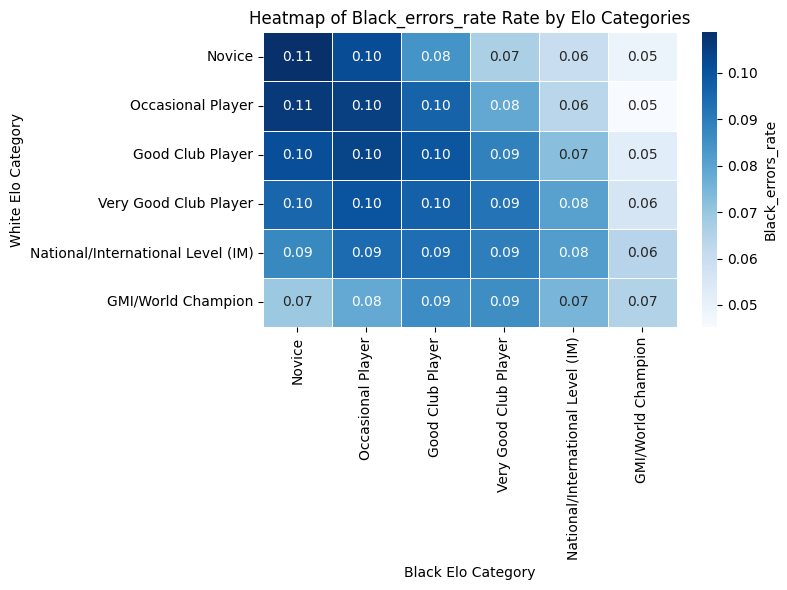

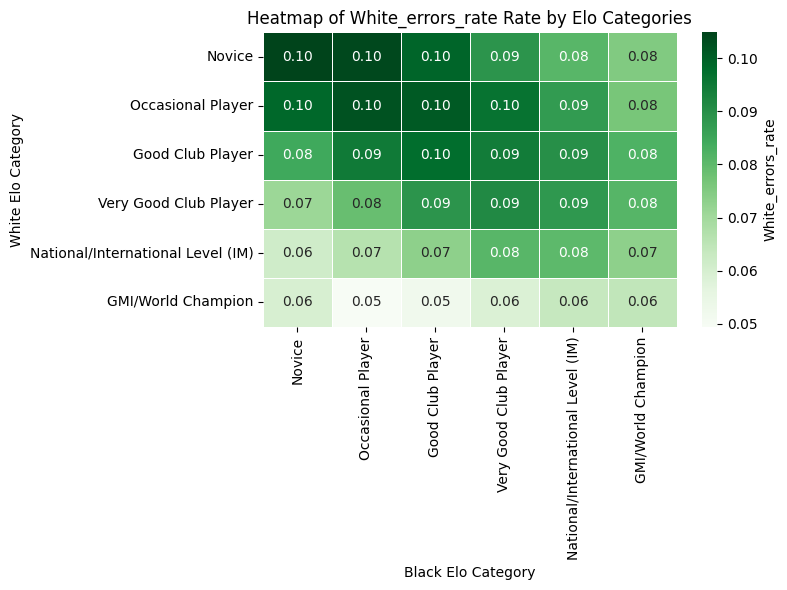

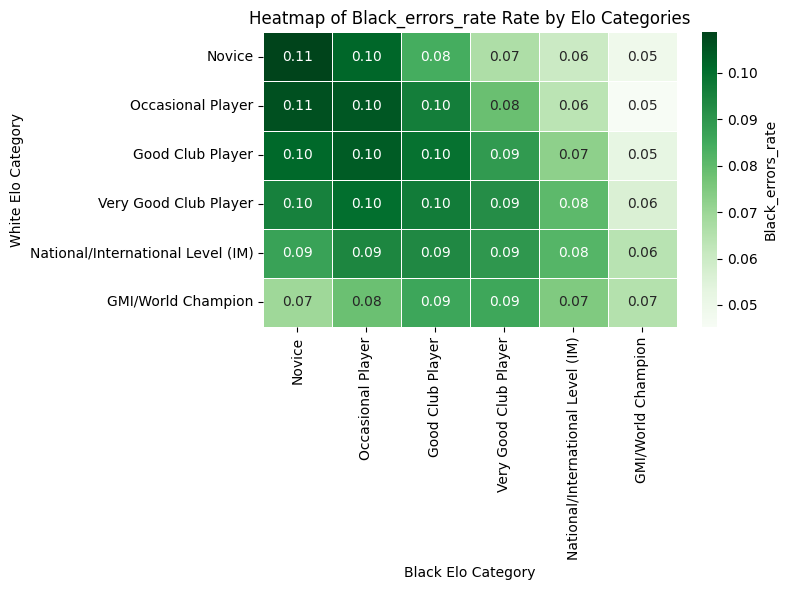

In [18]:
elo_order = [
    "Novice",
    "Occasional Player",
    "Good Club Player",
    "Very Good Club Player",
    "National/International Level (IM)",
    "GMI/World Champion",
]


def plot_error_rate(index, colors="Reds"):
  blunders_df = mistake_rates_pd.pivot(
      index="White_elo_category",
      columns="Black_elo_category",
      values=index
  )

  blunders_df = blunders_df.reindex(index=elo_order, columns=elo_order)

  plt.figure(figsize=(8, 6))
  sns.heatmap(
      blunders_df,
      annot=True,
      cmap=colors,
      fmt=".2f",
      linewidths=0.5,
      cbar_kws={'label': index}
  )
  plt.title("Heatmap of " + index + " Rate by Elo Categories")
  plt.ylabel("White Elo Category")
  plt.xlabel("Black Elo Category")
  plt.tight_layout()

  plt.show()

plot_error_rate("White_blunders_rate", "Reds")
plot_error_rate("Black_blunders_rate", "Reds")
plot_error_rate("White_errors_rate", "Blues")
plot_error_rate("Black_errors_rate", "Blues")
plot_error_rate("White_errors_rate", "Greens")
plot_error_rate("Black_errors_rate", "Greens")

Obviously, in lower rated players tend to make more mistakes than higher rated adversaries.

In [19]:
#I changed to the elo categories given by the teachers and now the graph is too cluttered

# mistake_rates_pd["Elo_Pair"] = mistake_rates_pd["White_elo_category"] + " vs " + mistake_rates_pd["Black_elo_category"]

# melted = mistake_rates_pd.melt(
#     id_vars=["Elo_Pair"],
#     value_vars=[
#         "White_blunders_rate", "White_errors_rate", "White_inaccuracies_rate",
#         "Black_blunders_rate", "Black_errors_rate", "Black_inaccuracies_rate"
#     ],
#     var_name="Mistake_Type",
#     value_name="Rate"
# )

# melted = melted.sort_values(by="Rate", ascending=False)

# plt.figure(figsize=(12, 8))
# sns.barplot(
#     data=melted,
#     x="Elo_Pair",
#     y="Rate",
#     hue="Mistake_Type",
#     palette="viridis",
#     order=melted["Elo_Pair"].unique()
# )
# plt.xticks(rotation=45, ha="right")
# plt.xlabel("Elo Pairing ; white vs black respectively")
# plt.ylabel("Rate")
# plt.title("Globally Ordered Mistake Rates by Elo Pairing and Mistake Type")
# plt.legend(title="Mistake Type", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


We show here the average number of errors, rather than the rate, since the rate is affected by the number of turns taken in a game.

In [20]:
mistake_quantity = df_blitz.groupBy("White_elo_category", "Black_elo_category").agg(
    (f.avg("White_blunders")).alias("White_blunders_avg"),
    (f.avg("White_mistakes")).alias("White_errors_avg"),
    (f.avg("White_inaccuracies")).alias("White_inaccuracies_avg"),
    (f.avg("Black_blunders")).alias("Black_blunders_avg"),
    (f.avg("Black_mistakes")).alias("Black_errors_avg"),
    (f.avg("Black_inaccuracies")).alias("Black_inaccuracies_avg")
)

In [21]:
mistake_quantity.show()

+--------------------+--------------------+------------------+------------------+----------------------+------------------+------------------+----------------------+
|  White_elo_category|  Black_elo_category|White_blunders_avg|  White_errors_avg|White_inaccuracies_avg|Black_blunders_avg|  Black_errors_avg|Black_inaccuracies_avg|
+--------------------+--------------------+------------------+------------------+----------------------+------------------+------------------+----------------------+
|Very Good Club Pl...|              Novice| 1.239920687376074|2.0482485128883012|    2.0264375413086584| 1.953734302709848|2.6801057501652346|    2.7349636483807007|
|National/Internat...|    Good Club Player|1.1932256932256933|2.4544577044577043|       2.4998244998245|1.7166549666549666|3.0737978237978236|    3.1187258687258685|
|              Novice|    Good Club Player|2.6592043348067875|2.9017538856409524|    2.9863111364608583| 2.021103664622843|2.4481676885783545|      2.45943248253244|
|Nat

## Exercice 2
What is the rate of victory per ouverture?

In [69]:
timecategories = [row["Game_type"] for row in df.select("Game_type").distinct().collect()]

In [70]:
timecategories

['Bullet', 'Blitz', 'Classical', 'Rapid', 'Correspondence']

In [72]:
opening_victory_rates = df.groupBy("Opening", "White_elo_category", "Black_elo_category", "Game_type").agg(
    (f.sum(f.when(col("Result") == "1-0", 1).otherwise(0)) / f.count("*")).alias("White_win_rate"),
    (f.sum(f.when(col("Result") == "0-1", 1).otherwise(0)) / f.count("*")).alias("Black_win_rate"),
)

### White

In [76]:
white_openings = df.groupBy("Opening", "White_elo_category", "Game_type").agg(
    (f.sum(f.when(col("Result") == "1-0", 1).otherwise(0)) / f.count("*")).alias("White_win_rate")
)

for timecategory in timecategories:
  for elo_category in elo_order:
      print(f"Top Openings for White ELO Category: {elo_category} - {timecategory}")
      white_openings.filter(col("White_elo_category") == elo_category)\
          .filter(col("Game_type") == timecategory)\
          .orderBy(col("White_win_rate").desc())\
          .show(truncate=False)

Top Openings for White ELO Category: Novice - Bullet
+--------------------------------------------------------------------------------+------------------+---------+--------------+
|Opening                                                                         |White_elo_category|Game_type|White_win_rate|
+--------------------------------------------------------------------------------+------------------+---------+--------------+
|Ruy Lopez: Cozio Defense, Paulsen Variation                                     |Novice            |Bullet   |1.0           |
|Vienna Game: Mengarini Variation                                                |Novice            |Bullet   |1.0           |
|English Opening: Anglo-Indian Defense, Anglo-Grünfeld Variation                 |Novice            |Bullet   |1.0           |
|Slav Defense: Smyslov Variation                                                 |Novice            |Bullet   |1.0           |
|King's Gambit Accepted, Abbazia Defense                  

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### Black openings

In [77]:
black_openings = df.groupBy("Opening", "Black_elo_category", "Game_type").agg(
    (f.sum(f.when(col("Result") == "0-1", 1).otherwise(0)) / f.count("*")).alias("Black_win_rate")
)

for timecategory in timecategories:
  for elo_category in elo_order:
      print(f"Top Openings for Black ELO Category: {elo_category} - {timecategory}")
      black_openings.filter(col("Black_elo_category") == elo_category)\
          .filter(col("Game_type") == timecategory)\
          .orderBy(col("Black_win_rate").desc())\
          .show(truncate=False)

Top Openings for Black ELO Category: Novice - Bullet
+--------------------------------------------------------+------------------+---------+--------------+
|Opening                                                 |Black_elo_category|Game_type|Black_win_rate|
+--------------------------------------------------------+------------------+---------+--------------+
|French Defense: Rubinstein Variation, Maric Variation   |Novice            |Bullet   |1.0           |
|English Opening: Agincourt Defense, Wimpy System        |Novice            |Bullet   |1.0           |
|Alekhine Defense: Modern Variation, Schmid Variation    |Novice            |Bullet   |1.0           |
|Slav Defense: Winawer Countergambit, Anti-Winawer Gambit|Novice            |Bullet   |1.0           |
|Scotch Game: Modern Defense                             |Novice            |Bullet   |1.0           |
|Nimzo-Indian Defense: Normal Variation, Hübner Deferred |Novice            |Bullet   |1.0           |
|Queen's Gambit Decl

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### ~

Of course, since the opening lines are extremely specific, some of them see very little play, and augment the probability of a side always winning.

It would be of interest to parse the string corresponding to the opening and do another analysis and reduce the openings to only the first section, before the colon. An analysis on shallower openings would more helpful results for players interested in picking the best line (It's easier to get into the Sicilian defense than the King's Indian Defense: Sämisch Variation, Panno Formation).



## Exercice 3
Can a difference in the attributes of a game, such as elo difference, blunder rate, etc, allow us to predict the outcome of a game and with which probability?

In [80]:
df.show(1)

+----+--------+---------------+----------+---+----------------+------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|     Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|black_elo_category|white_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_move

In [79]:
#A simple corelation
correlation = df.select("elo_diff", "white_win").stat.corr("elo_diff", "white_win")
print(f"Correlation between ello diff and probability of white winnning: {correlation}")


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `elodiff` cannot be resolved. Did you mean one of the following? [`Date`, `ECO`, `Event`, `GAME`, `Site`].;
'Project ['elodiff, 'white_win]
+- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, categorize_elo(BlackElo#5800)#6566 AS black_elo_category#6567, white_elo_category#6523, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
   +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, black_elo_category#6393, categorize_elo(WhiteElo#5811)#6522 AS white_elo_category#6523, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
      +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, black_elo_category#6393, white_elo_category#6349, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
         +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, black_elo_category#6393, white_elo_category#6349, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
            +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, categorize_elo(BlackElo#5800)#6392 AS black_elo_category#6393, white_elo_category#6349, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
               +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, black_elo_category#6010, categorize_elo(WhiteElo#5811)#6348 AS white_elo_category#6349, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
                  +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, black_elo_category#6010, white_elo_category#5966, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
                     +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, black_elo_category#6010, white_elo_category#5966, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
                        +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, categorize_elo(Blackelo#5800)#6009 AS black_elo_category#6010, white_elo_category#5966, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
                           +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, Black_elo_category#5813, categorize_elo(Whiteelo#5811)#5965 AS white_elo_category#5966, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
                              +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, Black_elo_category#5813, White_elo_category#5814, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 18 more fields]
                                 +- Project [GAME#5799, BlackElo#5800, BlackRatingDiff#5801, Date#5802, ECO#5803, Event#5804, Opening#5805, Result#5806, Site#5807, Termination#5808, TimeControl#5809, UTCTime#5810, WhiteElo#5811, WhiteRatingDiff#5812, Black_elo_category#5813, White_elo_category#5814, starting_time#5815, increment#5816, Game_type#5817, Total_moves#5818, Black_blunders#5819, White_blunders#5820, Black_mistakes#5821, White_mistakes#5822, ... 17 more fields]
                                    +- Relation [GAME#5799,BlackElo#5800,BlackRatingDiff#5801,Date#5802,ECO#5803,Event#5804,Opening#5805,Result#5806,Site#5807,Termination#5808,TimeControl#5809,UTCTime#5810,WhiteElo#5811,WhiteRatingDiff#5812,Black_elo_category#5813,White_elo_category#5814,starting_time#5815,increment#5816,Game_type#5817,Total_moves#5818,Black_blunders#5819,White_blunders#5820,Black_mistakes#5821,White_mistakes#5822,... 16 more fields] csv


In [ ]:
#Adding the label (outcome of the game)

def classify_result(result):
    if result == "1-0":
        return "White Victory"
    elif result == "0-1":
        return "Black Victory"
    elif result == "1/2-1/2":
        return "Stalemate"
    else:
        return "Unknown"

classify_result_udf = udf(classify_result, StringType())
df = df.withColumn("game_outcome", classify_result_udf(col("Result")))

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

feature_cols = ["Elo_diff", "White_blunders", "White_mistakes", "White_inaccuracies", "Game_flips"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


lr = LogisticRegression(labelCol="White_win", featuresCol="features")
model = lr.fit(train_df)
predictions = model.transform(test_df)


In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Result", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"acc: {accuracy: .2f}")


AUC: 0.7410493006658656


In [34]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

feature_cols = ["Elo_diff", "Total_moves", "White_blunders", "Black_blunders",
                "White_mistakes", "Black_mistakes", "White_inaccuracies", "Black_inaccuracies"]



indexer = StringIndexer(inputCol="Result", outputCol="Label")
df = indexer.fit(df).transform(df)

assembler = VectorAssembler(inputCols=feature_cols, outputCol="Features")
df = assembler.transform(df)

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42) #R

IllegalArgumentException: requirement failed: Output column Label already exists.

In [ ]:
rf = RandomForestClassifier(featuresCol="Features", labelCol="Label", numTrees=100)
model = rf.fit(train_data)

In [ ]:
predictions = model.transform(test_data)


evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")


feature_importance = list(zip(feature_cols, model.featureImportances))
print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")

In [ ]:
#test

new_data = spark.createDataFrame([
    (50,),
    (-100,),
    (0,)
], ["Elo_difference"])

new_data = VectorAssembler(inputCols=["Elo_difference"], outputCol="Features").transform(new_data)

predictions = model.transform(new_data)


predictions.select("Elo_difference", "probability").show()